In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPool2D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [51]:
input_shape = (28, 28, 1)
#set number of categories
num_category = 10
#It is always a good idea to initialize the random number generator to a constant to ensure that the results of your 
#script are reproducible.
#np.random.seed(25)

In [3]:
train = pd.read_csv("../../data/minst_train.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test = pd.read_csv("../../data/minst_test.csv")
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
x_train = (train.ix[:,1:].values).astype('float32') # all pixel values
y_train = train.ix[:,0].values.astype('int32') # only labels i.e targets digits

x_test = test.values.astype('float32')
# it is good practice to use a one hot encoding of the class values, transforming the vector of class integers into a binary matrix.
y_train = keras.utils.to_categorical(y_train, num_category)

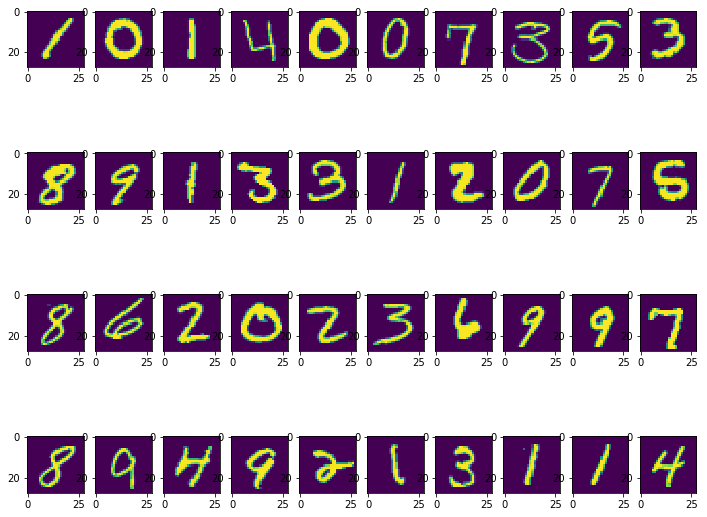

In [34]:
%matplotlib inline
# preview the images first
plt.figure(figsize=(12,10))
x, y = 10, 4
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i].reshape((28,28)),interpolation='nearest')
plt.show()

In [62]:
#normalize
x_train = x_train/255.0
x_test = x_test/255.0

In [63]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (42000, 784)
42000 train samples
28000 test samples


In [64]:
x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28,1)

#Copy of the array, cast to a specified type.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


In [65]:
# Three steps to Convolution
# 1. Convolution
# 2. Activation
# 3. Polling
# Repeat Steps 1,2,3 for adding more hidden layers

# 4. After that make a fully connected network
# This fully connected network gives ability to the CNN
# to classify the samples
def get_model():
    ##model building
    model = Sequential()
    #convolutional layer with rectified linear unit activation
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    #32 convolution filters used each of size 3x3
    #again
    model.add(Conv2D(64, (3, 3), activation='relu'))
    #64 convolution filters used each of size 3x3
    #choose the best features via pooling
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #randomly turn neurons on and off to improve convergence
    model.add(Dropout(0.25))
    #flatten since too many dimensions, we only want a classification output
    model.add(Flatten())
    #fully connected to get all relevant data
    model.add(Dense(128, activation='relu'))
    #one more dropout for convergence' sake :) 
    model.add(Dropout(0.5))
    #output a softmax to squash the matrix into output probabilities
    model.add(Dense(num_category, activation='softmax'))
    return model

In [66]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
__________

In [67]:
#Adaptive learning rate (adaDelta) is a popular form of gradient descent rivaled only by adam and adagrad
#categorical ce since we have multiple classes (10) 
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
x_train,x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=42)


In [68]:
batch_size = 128
num_epoch = 10
#model training
model_log = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,
          validation_data=(x_val, y_val))

Train on 42000 samples, validate on 42000 samples
Epoch 1/10
42000/42000 [==============================] - 83s 2ms/step - loss: 0.3317 - acc: 0.8956 - val_loss: 0.0707 - val_acc: 0.9789
Epoch 2/10
42000/42000 [==============================] - 78s 2ms/step - loss: 0.1059 - acc: 0.9684 - val_loss: 0.0492 - val_acc: 0.9849
Epoch 3/10
42000/42000 [==============================] - 77s 2ms/step - loss: 0.0769 - acc: 0.9764 - val_loss: 0.0331 - val_acc: 0.9895
Epoch 4/10
42000/42000 [==============================] - 117s 3ms/step - loss: 0.0625 - acc: 0.9813 - val_loss: 0.0379 - val_acc: 0.9877
Epoch 5/10
42000/42000 [==============================] - 80s 2ms/step - loss: 0.0535 - acc: 0.9838 - val_loss: 0.0254 - val_acc: 0.9918
Epoch 6/10
42000/42000 [==============================] - 85s 2ms/step - loss: 0.0480 - acc: 0.9852 - val_loss: 0.0176 - val_acc: 0.9946
Epoch 7/10
42000/42000 [==============================] - 83s 2ms/step - loss: 0.0406 - acc: 0.9871 - val_loss: 0.0154 - val_ac

In [69]:
#get the predictions for the test data
predicted_classes = model.predict_classes(x_test)


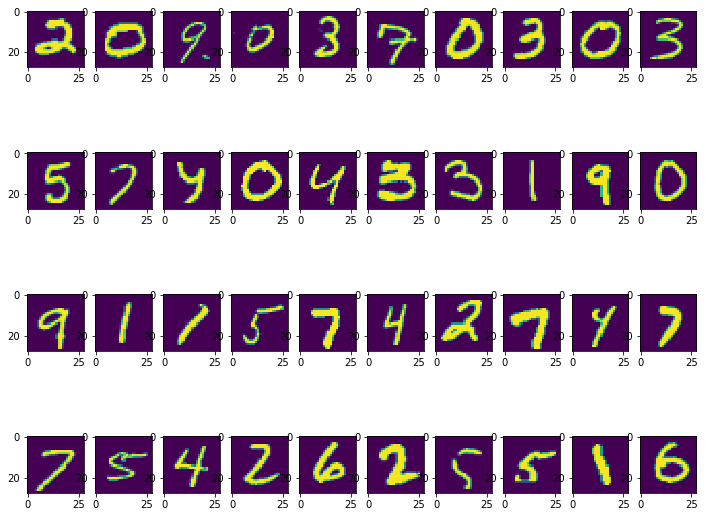

In [72]:
%matplotlib inline
# preview the images first
plt.figure(figsize=(12,10))
x, y = 10, 4
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_test[i].reshape((28,28)),interpolation='nearest')
plt.show()


In [75]:
predicted_classes[39]

6

In [76]:
model_json = model.to_json()
with open("model_json", "w") as json_file:
  json_file.write(model_json)
model.save_weights("model.h5")